# 1일 후의 하수처리량 예측 모델링
---
### 무엇을? 
- 1일 후의 하수처리량

### 어떻게? 
- 파생변수 추가
- EDA 간단하게 다시 진행
- 모델에 쓰지 않을 컬럼 제거
- 모델 학습, 학습 결과 비교

### 왜?
- 오늘까지의 정보를 기반으로 내일의 하수처리량을 예측하여 필요한 에너지, 자원 등을 더욱 효율적으로 사용할 수 있는 근거를 마련하고자 함

### 어떤 모델을?
1. 단순회귀 모델
2. LSTM, GRU
3. TabNet

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] ='Malgun Gothic' # 윈도우
# plt.rcParams['font.family'] ='AppleGothic' # 맥
plt.rcParams['axes.unicode_minus'] =False

### 파생변수
- 날짜 파생 
    - 트리 계열(랜덤포레스트/LightGBM/XGBoost): 
        - 월=1..12 같은 정수도 꽤 잘 다루지만, **12↔1의 연속성(원형성)**은 못 느낌
        - 그래서 12월과 1월이 멀리 떨어진 값으로 인식될 수 있음
        - = sin/cos로 순환 인코딩하면 월말->월초 경계가 매끄럽게 이어져서 보통 소폭이라도 좋아짐
    - 선형/신경망 계열(선형회귀, Lasso/Ridge, MLP, LSTM 등): 
        - 수치 자체의 순서에 민감해서, sin/cos 순환 인코딩이 거의 필수
        - 또한 요일 효과가 약해도, 월/연간 계절성은 강했으니, 최소한 월/연간(일-오브-이어) 주기는 sin/cos로 쓰는 게 이득일 가능성이 큼
        - 연은 추세 성격이라 **그냥 숫자(또는 표준화)**로 두는 게 보통 더 ㄱㅊ

==> 기존에 EDA 하면서 추가한 파생변수에서 수정

In [90]:
nanji = pd.read_csv('../data/processed/center_season/nanji/난지_merged.csv', encoding='utf-8-sig')
# nanji = pd.read_csv('../data/processed/center_season/nanji/nanji_for_eda.csv', encoding='utf-8-sig')
display(nanji)
nanji.info()

,날짜,요일,공휴일,목욕장업,세탁업,수영장업,종합체육시설업,체력단련장업,하천,생활인구,불쾌지수(DI),불쾌지수등급,일_일강수량(mm),일_최저기온(°C),일_평균기온(°C),일_최고기온(°C),일_평균풍속(m/s),일_최대순간풍속(m/s),최저습도(%),평균습도(%),최고습도(%),습도표준편차,1처리장,2처리장,정화조,중계펌프장,합계,계절
0,2017-01-01,일요일,1,210,939,28,26,779,0.0,1920764.58,41.04,쾌적,0.0,-0.55,3.68,7.53,1.13,3.92,65.67,77.11,87.17,7.02,212474.0,272541.0,725.0,7134,492874.0,겨울
1,2017-01-02,월요일,0,210,939,28,26,779,0.0,2011902.49,44.26,쾌적,0.0,2.05,5.73,9.43,1.65,6.43,61.67,77.49,89.00,8.72,224083.0,286338.0,4147.0,5968,520536.0,겨울
2,2017-01-03,화요일,0,210,939,28,26,779,0.0,2021411.02,40.93,쾌적,0.0,-1.20,2.55,7.22,1.43,5.95,42.17,63.13,83.00,11.54,205711.0,269835.0,4554.0,8354,488454.0,겨울
3,2017-01-04,수요일,0,210,939,28,26,779,0.0,2016146.44,43.66,쾌적,0.0,1.43,4.27,8.82,1.27,5.87,32.00,60.61,81.67,17.23,219468.0,277305.0,5100.0,8307,510180.0,겨울
4,2017-01-05,목요일,0,210,939,28,26,779,0.0,2019225.84,44.70,쾌적,0.0,0.18,4.63,7.68,2.43,8.27,43.83,55.00,63.17,6.02,207189.0,275215.0,5733.0,8152,496289.0,겨울
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3098,2025-06-26,목요일,0,120,515,22,20,618,7.0,1820483.24,69.53,약간 불쾌,4.5,19.15,21.32,24.17,1.02,4.57,77.17,88.15,96.83,6.73,0.0,0.0,0.0,0,0.0,여름
3099,2025-06-27,금요일,0,120,515,22,20,618,0.0,1818477.77,73.74,약간 불쾌,0.0,20.02,24.35,29.27,0.97,5.17,61.50,79.09,91.83,10.05,0.0,0.0,0.0,0,0.0,여름
3100,2025-06-28,토요일,0,120,515,22,20,618,3.5,1751408.17,76.13,불쾌,2.5,23.30,25.38,27.73,0.90,4.50,79.00,85.97,93.00,4.19,0.0,0.0,0.0,0,0.0,여름
3101,2025-06-29,일요일,0,120,515,22,20,618,0.0,1716949.92,77.05,불쾌,0.5,23.78,26.38,30.63,1.35,5.70,62.50,79.58,92.50,9.26,0.0,0.0,0.0,0,0.0,여름


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3103 entries, 0 to 3102
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   날짜             3103 non-null   object 
 1   요일             3103 non-null   object 
 2   공휴일            3103 non-null   int64  
 3   목욕장업           3103 non-null   int64  
 4   세탁업            3103 non-null   int64  
 5   수영장업           3103 non-null   int64  
 6   종합체육시설업        3103 non-null   int64  
 7   체력단련장업         3103 non-null   int64  
 8   하천             3103 non-null   float64
 9   생활인구           3103 non-null   float64
 10  불쾌지수(DI)       3103 non-null   float64
 11  불쾌지수등급         3103 non-null   object 
 12  일_일강수량(mm)     3103 non-null   float64
 13  일_최저기온(°C)     3103 non-null   float64
 14  일_평균기온(°C)     3103 non-null   float64
 15  일_최고기온(°C)     3103 non-null   float64
 16  일_평균풍속(m/s)    3103 non-null   float64
 17  일_최대순간풍속(m/s)  3103 non-null   float64
 18  최저습도(%) 

In [91]:
# 안전: 날짜 정렬
nanji['날짜'] = pd.to_datetime(nanji['날짜'])
nanji = nanji.sort_values('날짜').reset_index(drop=True)
# 난지 6월 데이터 없음 -> 다 0으로 되어 있으니까 제거 
nanji = nanji[nanji["날짜"] < "2025-06-01"] 

# -------------------------
# 1. 날짜 파생 (순환 인코딩)
# -------------------------
def add_cyclical_features(df, date_col='날짜'):
    d = df[date_col].dt

    # 월
    df['월_sin'] = np.sin(2*np.pi*d.month/12)
    df['월_cos'] = np.cos(2*np.pi*d.month/12)

    # 요일
    dow = d.weekday
    df['요일_sin'] = np.sin(2*np.pi*dow/7)
    df['요일_cos'] = np.cos(2*np.pi*dow/7)

    # 연중일
    doy = d.dayofyear
    df['연중일_sin'] = np.sin(2*np.pi*doy/365.25)
    df['연중일_cos'] = np.cos(2*np.pi*doy/365.25)
    return df

nanji = add_cyclical_features(nanji)

# -------------------------
# 2. 라그 (lag) : 과거 값
# -------------------------
add_lag_specs = {
    '일_평균기온(°C)': [1, 3],
    '일_최고기온(°C)': [1, 3],
    '일_최저기온(°C)': [1, 3],
    '평균습도(%)': [1, 3],
    '불쾌지수(DI)': [1, 3],
    '하천': [1, 3],
    '일_평균풍속(m/s)': [1],  # 영향 약할 수 있어 가볍게
    '합계': [1,3,7],
    '생활인구': [1,3,7],
    '일_일강수량(mm)': [1,3],
}
for col, lags in add_lag_specs.items():
    for L in lags:
        nanji[f'{col}_lag{L}'] = nanji[col].shift(L)

# -------------------------
# 3. 롤링 (오늘까지) : 누적값
# -------------------------
nanji['합계_roll7_mean'] = nanji['합계'].rolling(7, min_periods=1).mean()
nanji['합계_roll7_std']  = nanji['합계'].rolling(7, min_periods=2).std()
nanji['생활인구_roll7_mean'] = nanji['생활인구'].rolling(7, min_periods=1).mean()
nanji['강수량_roll3_sum'] = nanji['일_일강수량(mm)'].rolling(3, min_periods=1).sum()
nanji['강수량_roll7_sum'] = nanji['일_일강수량(mm)'].rolling(7, min_periods=1).sum()

# -------------------------
# 4. 변화율/증감
# -------------------------
nanji['합계_전일증감률']    = nanji['합계'].pct_change()
nanji['합계_전일변화']      = nanji['합계'].diff()
nanji['생활인구_전일증감률'] = nanji['생활인구'].pct_change()
nanji['강수량_전일변화']    = nanji['일_일강수량(mm)'].diff()

# -------------------------
# 5. 날씨/이벤트
# -------------------------
nanji['일교차']   = nanji['일_최고기온(°C)'] - nanji['일_최저기온(°C)']
nanji['체감온도'] = nanji['일_평균기온(°C)'] - 0.7*nanji['일_평균풍속(m/s)']
nanji['습도차이'] = nanji['최고습도(%)'] - nanji['최저습도(%)']

nanji['강수_여부'] = (nanji['일_일강수량(mm)'] > 0).astype(int)
nanji['폭우_여부'] = (nanji['일_일강수량(mm)'] >= 80).astype(int)
nanji['폭염일']    = (nanji['일_최고기온(°C)'] >= 33).astype(int)
nanji['한파_여부'] = (nanji['일_최저기온(°C)'] <= -12).astype(int)

# -------------------------
# 6. 인허가 파생
# -------------------------
nanji['인허가'] = nanji[['목욕장업','세탁업','수영장업','종합체육시설업','체력단련장업']].sum(axis=1)

# -------------------------
# 7. 타깃 생성 (항상 마지막)
# -------------------------
nanji['합계_1일후'] = nanji['합계'].shift(-1)
nanji['합계_2일후'] = nanji['합계'].shift(-2)

# 요일 숫자로
nanji['요일_숫자'] = nanji['날짜'].dt.weekday # 0:월요일, 1:화요일, ... , 6:일요일

# 계절, 불쾌지수등급 숫자로
nanji = nanji.replace(
    {
        '계절': {'봄': 0, '여름' : 1, '가을' : 2, '겨울' : 3},
        '불쾌지수등급' : {'쾌적' : 0, '약간 불쾌' : 1, '불쾌' : 2, '매우 불쾌' : 3, '극심한 불쾌' : 4}
     })



nanji.columns

C:\Users\user\AppData\Local\Temp\ipykernel_21544\2456140131.py:93: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  nanji = nanji.replace(


Index(['날짜', '요일', '공휴일', '목욕장업', '세탁업', '수영장업', '종합체육시설업', '체력단련장업', '하천',
       '생활인구', '불쾌지수(DI)', '불쾌지수등급', '일_일강수량(mm)', '일_최저기온(°C)', '일_평균기온(°C)',
       '일_최고기온(°C)', '일_평균풍속(m/s)', '일_최대순간풍속(m/s)', '최저습도(%)', '평균습도(%)',
       '최고습도(%)', '습도표준편차', '1처리장', '2처리장', '정화조', '중계펌프장', '합계', '계절',
       '월_sin', '월_cos', '요일_sin', '요일_cos', '연중일_sin', '연중일_cos',
       '일_평균기온(°C)_lag1', '일_평균기온(°C)_lag3', '일_최고기온(°C)_lag1',
       '일_최고기온(°C)_lag3', '일_최저기온(°C)_lag1', '일_최저기온(°C)_lag3', '평균습도(%)_lag1',
       '평균습도(%)_lag3', '불쾌지수(DI)_lag1', '불쾌지수(DI)_lag3', '하천_lag1', '하천_lag3',
       '일_평균풍속(m/s)_lag1', '합계_lag1', '합계_lag3', '합계_lag7', '생활인구_lag1',
       '생활인구_lag3', '생활인구_lag7', '일_일강수량(mm)_lag1', '일_일강수량(mm)_lag3',
       '합계_roll7_mean', '합계_roll7_std', '생활인구_roll7_mean', '강수량_roll3_sum',
       '강수량_roll7_sum', '합계_전일증감률', '합계_전일변화', '생활인구_전일증감률', '강수량_전일변화', '일교차',
       '체감온도', '습도차이', '강수_여부', '폭우_여부', '폭염일', '한파_여부', '인허가', '합계_1일후',
       '합계_2일후', '요일_숫자'],
      d

In [92]:
nanji.isnull().sum().sort_values(ascending=False)

생활인구_lag7          7
합계_lag7            7
생활인구_lag3          3
일_최저기온(°C)_lag3    3
평균습도(%)_lag3       3
                  ..
폭우_여부              0
한파_여부              0
폭염일                0
인허가                0
요일_숫자              0
Length: 75, dtype: int64

In [93]:
nanji = nanji.dropna().reset_index(drop=True)
nanji.isnull().sum().sort_values(ascending=False)

날짜        0
요일        0
공휴일       0
목욕장업      0
세탁업       0
         ..
한파_여부     0
인허가       0
합계_1일후    0
합계_2일후    0
요일_숫자     0
Length: 75, dtype: int64

In [94]:
nanji.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3064 entries, 0 to 3063
Data columns (total 75 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   날짜                3064 non-null   datetime64[ns]
 1   요일                3064 non-null   object        
 2   공휴일               3064 non-null   int64         
 3   목욕장업              3064 non-null   int64         
 4   세탁업               3064 non-null   int64         
 5   수영장업              3064 non-null   int64         
 6   종합체육시설업           3064 non-null   int64         
 7   체력단련장업            3064 non-null   int64         
 8   하천                3064 non-null   float64       
 9   생활인구              3064 non-null   float64       
 10  불쾌지수(DI)          3064 non-null   float64       
 11  불쾌지수등급            3064 non-null   int64         
 12  일_일강수량(mm)        3064 non-null   float64       
 13  일_최저기온(°C)        3064 non-null   float64       
 14  일_평균기온(°C)        3064 n

In [95]:
nanji.columns

Index(['날짜', '요일', '공휴일', '목욕장업', '세탁업', '수영장업', '종합체육시설업', '체력단련장업', '하천',
       '생활인구', '불쾌지수(DI)', '불쾌지수등급', '일_일강수량(mm)', '일_최저기온(°C)', '일_평균기온(°C)',
       '일_최고기온(°C)', '일_평균풍속(m/s)', '일_최대순간풍속(m/s)', '최저습도(%)', '평균습도(%)',
       '최고습도(%)', '습도표준편차', '1처리장', '2처리장', '정화조', '중계펌프장', '합계', '계절',
       '월_sin', '월_cos', '요일_sin', '요일_cos', '연중일_sin', '연중일_cos',
       '일_평균기온(°C)_lag1', '일_평균기온(°C)_lag3', '일_최고기온(°C)_lag1',
       '일_최고기온(°C)_lag3', '일_최저기온(°C)_lag1', '일_최저기온(°C)_lag3', '평균습도(%)_lag1',
       '평균습도(%)_lag3', '불쾌지수(DI)_lag1', '불쾌지수(DI)_lag3', '하천_lag1', '하천_lag3',
       '일_평균풍속(m/s)_lag1', '합계_lag1', '합계_lag3', '합계_lag7', '생활인구_lag1',
       '생활인구_lag3', '생활인구_lag7', '일_일강수량(mm)_lag1', '일_일강수량(mm)_lag3',
       '합계_roll7_mean', '합계_roll7_std', '생활인구_roll7_mean', '강수량_roll3_sum',
       '강수량_roll7_sum', '합계_전일증감률', '합계_전일변화', '생활인구_전일증감률', '강수량_전일변화', '일교차',
       '체감온도', '습도차이', '강수_여부', '폭우_여부', '폭염일', '한파_여부', '인허가', '합계_1일후',
       '합계_2일후', '요일_숫자'],
      d

In [96]:
# 학습에 사용하지 않을 컬럼
'''
목표: y_{t+1} = 내일 하수처리량
사용 가능한 정보: 시점 t (오늘까지) 의 관측값
사용하면 안 되는 정보: 시점 t+1 (내일 이후) 의 관측값
'''
not_use_col = [
    # 날짜 원본
    '날짜', 
    # 범주형 컬럼
    '요일',
    # 1일 후 합계에 직접적인 영향을 주는 값
    '1처리장', '2처리장', '정화조', '중계펌프장', '합계',
    # 원본 데이터를 직접 사용하는 것보다 lag, rolling 값 사용이 더 안전할수도?
    '일_일강수량(mm)', '생활인구',
    # 타겟값
    '합계_1일후', '합계_2일후'
]



In [97]:
# %% [markdown]
# # TimeSeriesSplit CV + RF/XGB/CatBoost/LGBM + FI/Permutation Importance/SHAP/LIME
# - RMSE 버전 의존성 문제 해결 (수동 RMSE)
# - 모델별 CV 성능 비교
# - 모델별 Feature Importance
# - Best 모델에 대해 Permutation Importance
# - SHAP, LIME 단일 샘플 설명 (선택적으로 실행)

# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

from sklearn.ensemble import RandomForestRegressor

# xgboost / catboost / lightgbm은 설치 여부에 따라 다를 수 있음 → try/except로 안전 처리
has_xgb = has_cat = has_lgbm = True
try:
    from xgboost import XGBRegressor
except Exception as e:
    has_xgb = False
    print("[WARN] xgboost 미설치 또는 임포트 실패:", e)

try:
    from catboost import CatBoostRegressor
except Exception as e:
    has_cat = False
    print("[WARN] catboost 미설치 또는 임포트 실패:", e)

try:
    from lightgbm import LGBMRegressor
except Exception as e:
    has_lgbm = False
    print("[WARN] lightgbm 미설치 또는 임포트 실패:", e)

# -------------------------
# 0) X, y 구성 (이미 nanji 구축/전처리 끝난 상태 가정)
#    not_use_col은 사용자가 정의한 리스트를 그대로 활용
# -------------------------
not_use_col = [
    '날짜', '요일',
    '1처리장', '2처리장', '정화조', '중계펌프장', '합계',
    '일_일강수량(mm)', '생활인구',
    '합계_1일후','합계_2일후'
]

# 존재하는 컬럼만 feature로 사용
feature_cols = [c for c in nanji.columns if c not in not_use_col]
df_model = nanji.dropna(subset=['합계_1일후']).reset_index(drop=True)

X = df_model[feature_cols].copy()
y = df_model['합계_1일후'].copy()

print(f"[INFO] X.shape={X.shape}, y.shape={y.shape}")
print(f"[INFO] 기간: {df_model['날짜'].min().date()} ~ {df_model['날짜'].max().date()}")

# -------------------------
# 1) TimeSeriesSplit
# -------------------------
tscv = TimeSeriesSplit(n_splits=5)

def rmse(y_true, y_pred):
    # 버전 무관하게 동작하는 RMSE 계산
    return float(np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2)))

# -------------------------
# 2) 모델 정의
# -------------------------
models = {
    "RandomForest": RandomForestRegressor(
        n_estimators=400, max_depth=None, random_state=42, n_jobs=-1
    )
}

if has_xgb:
    models["XGB"] = XGBRegressor(
        n_estimators=600, max_depth=6, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8,
        random_state=42, n_jobs=-1,
        objective="reg:squarederror",  # 명시적으로 설정
        eval_metric="rmse"             # 경고 억제
    )

if has_cat:
    models["CatBoost"] = CatBoostRegressor(
        iterations=700, depth=6, learning_rate=0.05,
        random_state=42, verbose=0, loss_function='RMSE'
    )

if has_lgbm:
    models["LGBM"] = LGBMRegressor(
        n_estimators=700, max_depth=-1, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
    )

# -------------------------
# 3) CV 학습 + 평가
# -------------------------
cv_scores = {}
fold_predictions = {}   # 필요시 예측 보관
fitted_models = {}      # 마지막 fold의 학습 모델 보관(중요도/SHAP에 사용)

for name, model in models.items():
    rmses = []
    preds_all = []
    for fold, (tr_idx, va_idx) in enumerate(tscv.split(X), 1):
        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

        model.fit(X_tr, y_tr)
        y_hat = model.predict(X_va)
        score = rmse(y_va, y_hat)
        rmses.append(score)

        preds_all.append(pd.DataFrame({
            "idx": va_idx,
            "y": y_va.values,
            "y_hat": y_hat
        }))
        print(f"[{name}] Fold {fold} RMSE = {score:,.0f}")

    cv_scores[name] = (np.mean(rmses), np.std(rmses))
    fold_predictions[name] = pd.concat(preds_all).sort_values("idx").reset_index(drop=True)
    fitted_models[name] = model
    print(f"[{name}] CV RMSE = {np.mean(rmses):,.0f} ± {np.std(rmses):,.0f}\n")

print("=== Summary (CV RMSE) ===")
for k, (m, s) in cv_scores.items():
    print(f"{k:<12} {m:,.0f} ± {s:,.0f}")


[INFO] X.shape=(3064, 64), y.shape=(3064,)
[INFO] 기간: 2017-01-08 ~ 2025-05-29
[RandomForest] Fold 1 RMSE = 103,978
[RandomForest] Fold 2 RMSE = 82,028
[RandomForest] Fold 3 RMSE = 87,596
[RandomForest] Fold 4 RMSE = 106,750
[RandomForest] Fold 5 RMSE = 72,639
[RandomForest] CV RMSE = 90,598 ± 12,999

[XGB] Fold 1 RMSE = 98,917
[XGB] Fold 2 RMSE = 77,637
[XGB] Fold 3 RMSE = 91,699
[XGB] Fold 4 RMSE = 104,194
[XGB] Fold 5 RMSE = 76,489
[XGB] CV RMSE = 89,787 ± 11,127

[CatBoost] Fold 1 RMSE = 84,742
[CatBoost] Fold 2 RMSE = 77,164
[CatBoost] Fold 3 RMSE = 89,529
[CatBoost] Fold 4 RMSE = 97,054
[CatBoost] Fold 5 RMSE = 74,211
[CatBoost] CV RMSE = 84,540 ± 8,278

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6971
[LightGBM] [Info] Number of data points in the train set: 514, number of used features: 61
[LightGBM] [Info] Start training from score 5

In [ ]:
너는 실력 좋은 데이터분석가이자 데이터사이언티스트야. 파이썬 코드를 줄 때는 .ipynb(파이썬) 파일 형식으로 항상 알려줘. 그리고 모든 코드에 주석을 달아서 설명해줘.
내가 요구하기 전까지는 파일로 주지 말고 먼저 채팅창에 보내줘

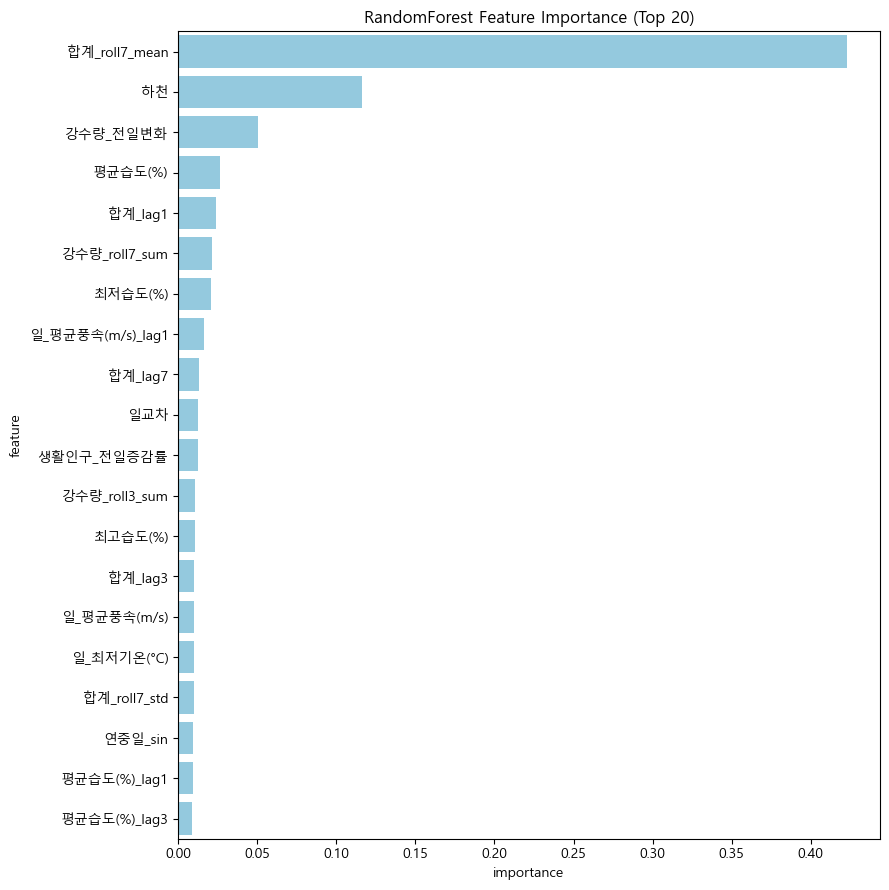

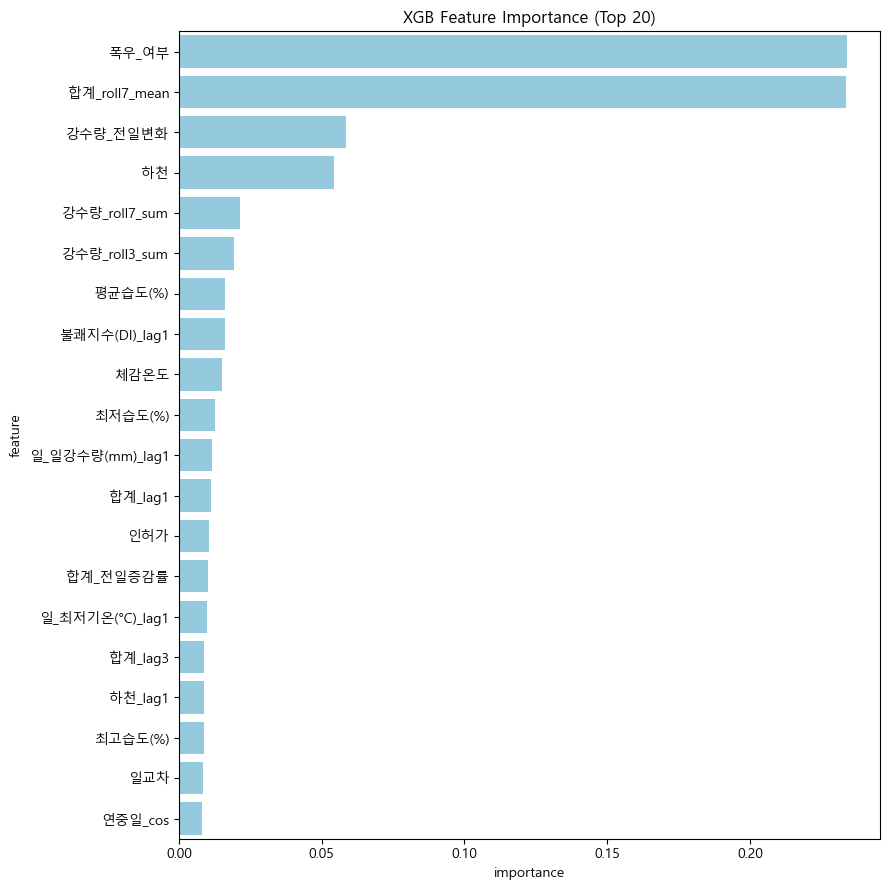

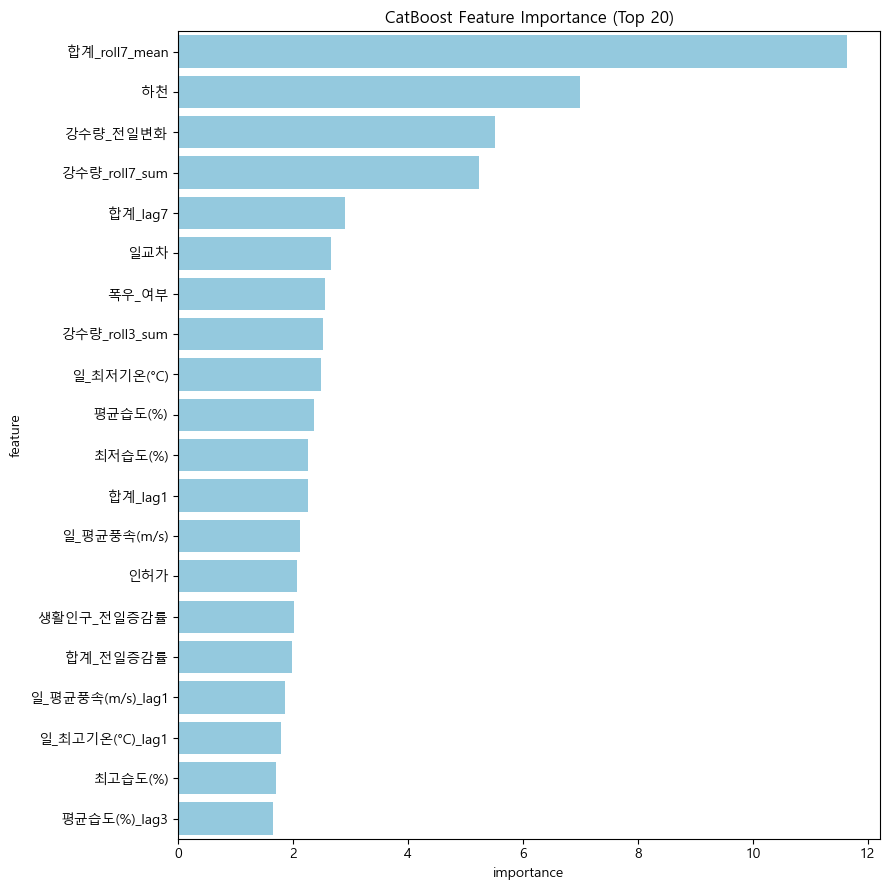

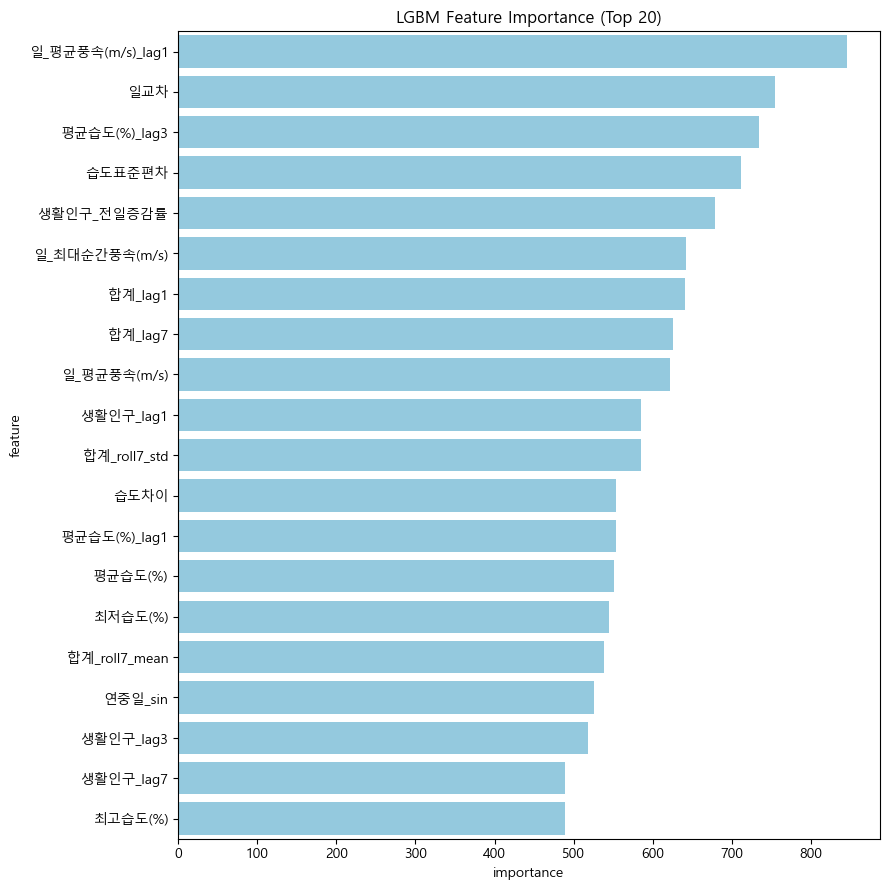

In [98]:
# %% [markdown]
# ## 4) 모델별 Feature Importance (내장) 시각화
# - Tree 계열: feature_importances_ 사용 가능
# - CatBoost도 .get_feature_importance() 제공
# - seaborn 경고 피하려고 단색(color) 사용

# %%
def plot_feature_importance(model, X, title, topn=20):
    if hasattr(model, "feature_importances_"):
        imp = model.feature_importances_
    elif "CatBoost" in model.__class__.__name__:
        try:
            imp = model.get_feature_importance()
        except:
            print("[WARN] CatBoost 중요도 추출 실패")
            return
    else:
        print("[WARN] 이 모델은 내장 중요도가 없습니다:", model.__class__.__name__)
        return

    fi = (pd.DataFrame({"feature": X.columns, "importance": imp})
          .sort_values("importance", ascending=False))

    plt.figure(figsize=(9, 0.45*min(topn, len(fi))))
    sns.barplot(data=fi.head(topn), x="importance", y="feature", color="skyblue")
    plt.title(title)
    plt.tight_layout()
    plt.show()

for name, model in fitted_models.items():
    plot_feature_importance(model, X, f"{name} Feature Importance (Top 20)", topn=20)


[INFO] Best model by CV: CatBoost


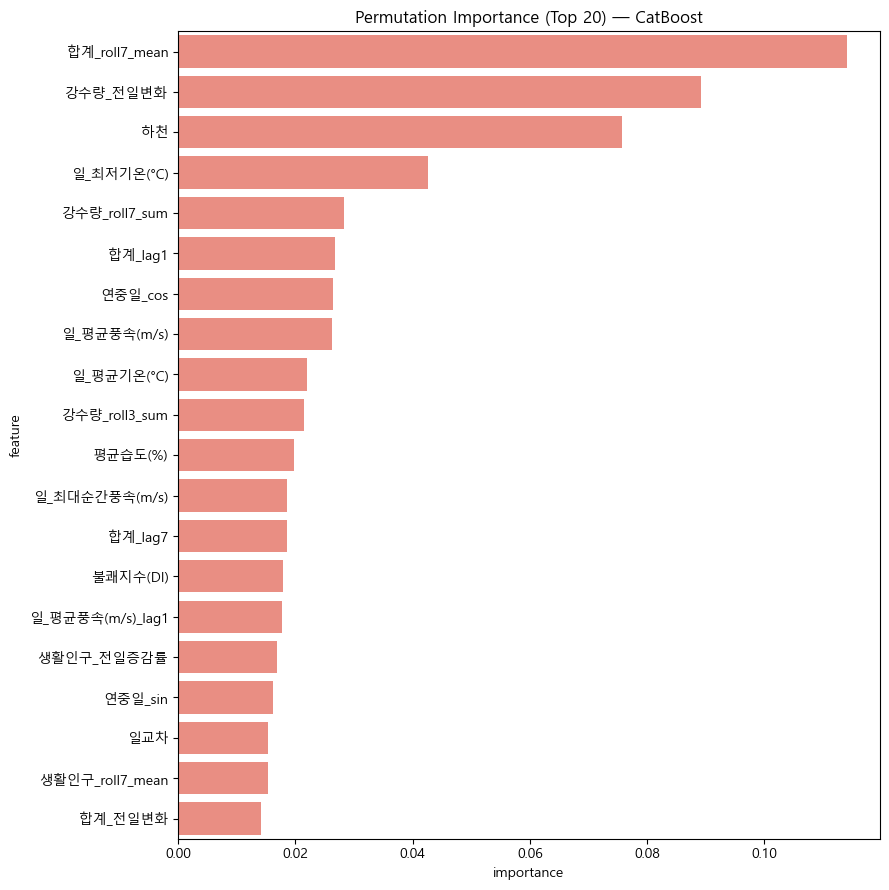

,feature,importance,std
46,합계_roll7_mean,0.114040,0.003475
54,강수량_전일변화,0.089160,0.003234
6,하천,0.075657,0.002396
9,일_최저기온(°C),0.042679,0.000974
50,강수량_roll7_sum,0.028317,0.000983
38,합계_lag1,0.026726,0.001048
24,연중일_cos,0.026480,0.001088
12,일_평균풍속(m/s),0.026217,0.001055
10,일_평균기온(°C),0.021963,0.000785
49,강수량_roll3_sum,0.021470,0.000939


In [99]:
# %% [markdown]
# ## 5) Permutation Importance (Best 모델 기준)
# - CV 성능이 가장 좋은 모델 하나를 골라 전체 데이터에 적합 후 Permutation Importance 계산
# - n_repeats는 상황에 따라 늘릴 수 있음 (시간 증가)

# %%
best_name = min(cv_scores, key=lambda k: cv_scores[k][0])  # RMSE 평균 최소 모델 선택
best_model = models[best_name]
print(f"[INFO] Best model by CV: {best_name}")

# 전체 데이터 적합(설명용)
best_model.fit(X, y)

perm = permutation_importance(best_model, X, y, n_repeats=8, random_state=42)

perm_df = (pd.DataFrame({
    "feature": X.columns,
    "importance": perm.importances_mean,
    "std": perm.importances_std
}).sort_values("importance", ascending=False))

plt.figure(figsize=(9, 0.45*min(20, len(perm_df))))
sns.barplot(data=perm_df.head(20), x="importance", y="feature", color="salmon")
plt.title(f"Permutation Importance (Top 20) — {best_name}")
plt.tight_layout()
plt.show()

perm_df.head(20)


c:\Users\user\anaconda3\envs\young\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


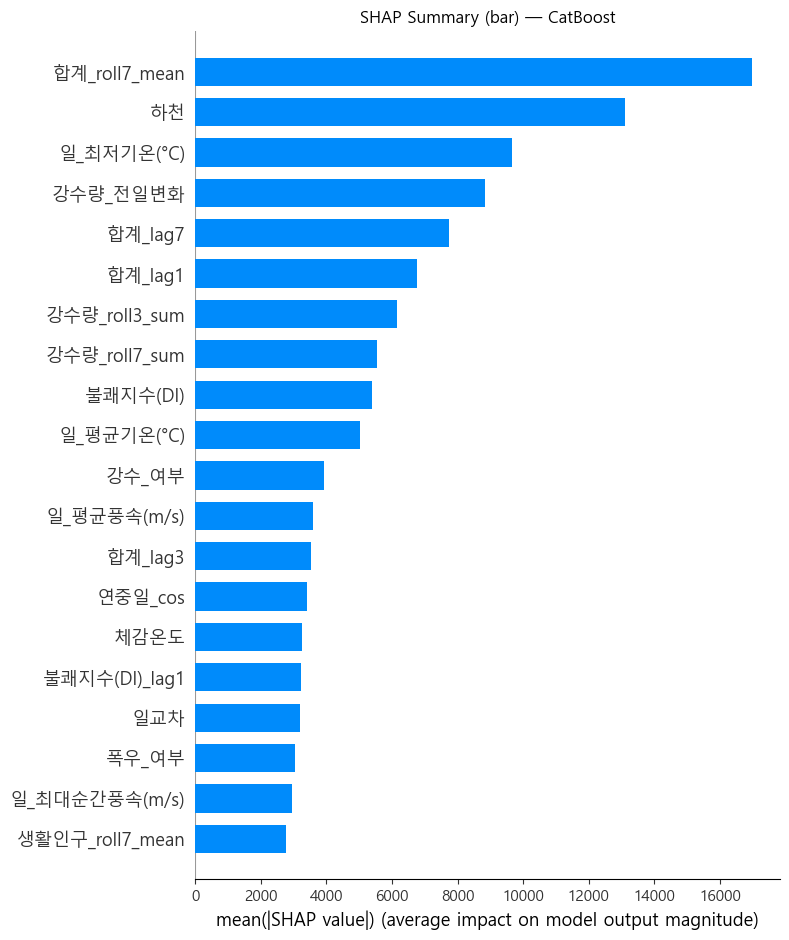

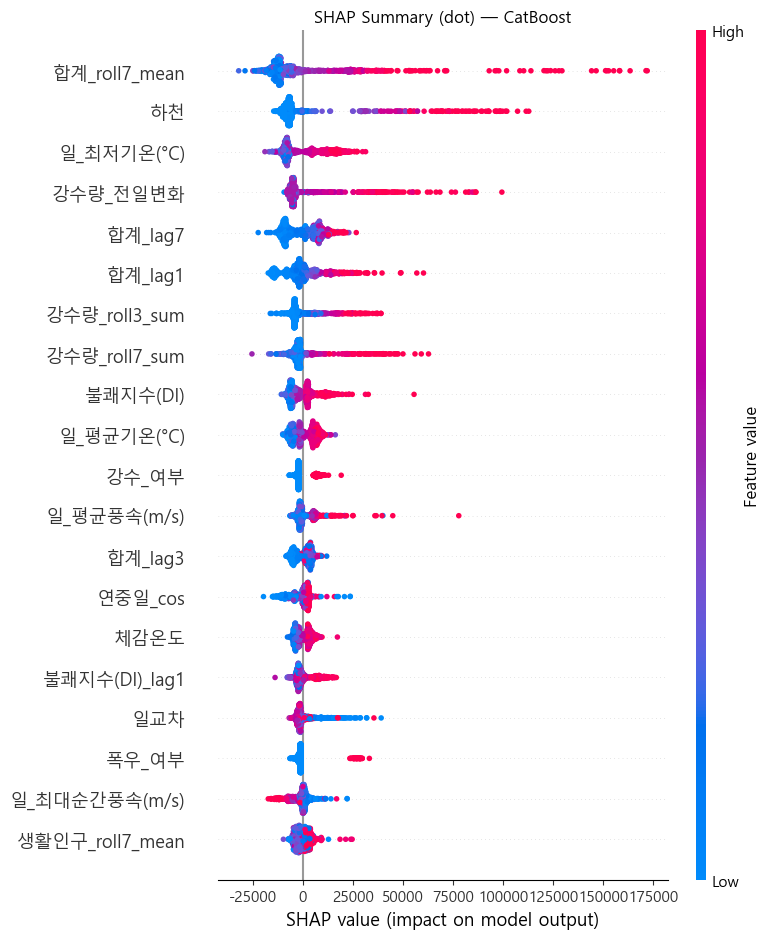

In [100]:
# %% [markdown]
# ## 6) SHAP (선택) — Tree 계열 모델에 적합
# - 설치 필요: shap
# - 해석: summary_plot(bar) = 전반적 중요도, summary_plot(dot) = 영향 방향/분포
# - 데이터가 크면 샘플링 사용 권장

# %%
try:
    import shap
    shap.initjs()

    # TreeExplainer는 트리 계열에 최적화 (RF/XGB/LGBM/CatBoost)
    explainer = shap.TreeExplainer(best_model)
    # 계산량 줄이기 위해 일부 샘플만 (예: 1000개)
    nsample = min(1000, len(X))
    X_sample = X.sample(nsample, random_state=42)

    shap_values = explainer.shap_values(X_sample)

    # 전반적 중요도 (bar)
    shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
    plt.title(f"SHAP Summary (bar) — {best_name}")
    plt.tight_layout()
    plt.show()

    # 영향 방향/분포 (dot)
    shap.summary_plot(shap_values, X_sample, show=False)
    plt.title(f"SHAP Summary (dot) — {best_name}")
    plt.tight_layout()
    plt.show()

    # 단일 샘플 force_plot (노트북에서만 인터랙티브)
    one_idx = X_sample.index[0]
    shap.force_plot(explainer.expected_value, shap_values[0], X_sample.iloc[0,:])
except Exception as e:
    print("[WARN] SHAP 실행 건너뜀:", e)


In [101]:
# %% [markdown]
# ## 7) LIME (선택) — 단일 예측에 대한 지역적 설명
# - 설치 필요: lime
# - 수치형 전처리 없이도 동작하지만, 스케일이 매우 다르면 표준화 후 사용하는 것을 권장

# %%
try:
    from lime.lime_tabular import LimeTabularExplainer

    # 훈련 데이터 기반으로 LIME 설명자 생성
    explainer = LimeTabularExplainer(
        training_data=np.array(X),
        feature_names=X.columns.tolist(),
        mode='regression',
        discretize_continuous=False  # 연속형 그대로
    )

    # 임의의 샘플 1개 선택
    i = np.random.randint(0, len(X))
    x_i = np.array(X.iloc[i])
    exp = explainer.explain_instance(
        data_row=x_i,
        predict_fn=best_model.predict,
        num_features=10
    )
    # 노트북에서는 exp.show_in_notebook() 가능
    print("[LIME] sample index:", i)
    for feat, weight in exp.as_list():
        print(f"{feat:60s} {weight:+.4f}")

except Exception as e:
    print("[WARN] LIME 실행 건너뜀:", e)


[LIME] sample index: 612
하천                                                           +22540.3167
일_평균풍속(m/s)_lag1                                             -12069.7535
일_평균기온(°C)                                                   +9166.4382
일_최저기온(°C)                                                   +8754.3028
연중일_sin                                                      +6298.8285
불쾌지수(DI)                                                     +5394.9812
일_최고기온(°C)_lag3                                              -4334.8143
체감온도                                                         +4157.2550
체력단련장업                                                       -3141.7246
생활인구_lag7                                                    -2493.7888


In [102]:
# %% [markdown]
# ## 1) 학습 데이터셋(X, y) 구성
# - 타깃: 합계_1일후 (shift(-1))
# - 피처: 오늘까지 정보 + 순환 인코딩 + 라그/롤링 + 이벤트/인허가
# - dropna로 라그/롤링 초반 결측 제거

# %%
target = '합계_1일후'
feature_cols = [
    # 계절성(순환)
    '월_sin','월_cos','요일_sin','요일_cos','연중일_sin','연중일_cos',
    # 자기상관/지연
    '합계_lag1','합계_lag3','합계_lag7',
    '생활인구_lag1','생활인구_lag3','생활인구_lag7',
    '일_일강수량(mm)_lag1','일_일강수량(mm)_lag3',
    # 롤링(오늘까지)
    '합계_roll7_mean','합계_roll7_std',
    '생활인구_roll7_mean',
    '강수량_roll3_sum','강수량_roll7_sum',
    # 변화/이벤트/날씨
    '합계_전일증감률','합계_전일변화','생활인구_전일증감률','강수량_전일변화',
    '일교차','체감온도','습도차이','강수_여부','폭우_여부','폭염일','한파_여부',
    # 느린 추세
    '인허가','인허가_누적',
    # 보강용 정수형 계절/쾌적도(순환과 함께 쓰되, 트리 모델이면 문제 없음)
    '계절','불쾌지수등급'
]

# 실제 존재하는 컬럼만 사용(안전)
feature_cols = [c for c in feature_cols if c in nanji.columns]

df_model = nanji[['날짜', target] + feature_cols].dropna().reset_index(drop=True)
X = df_model[feature_cols].copy()
y = df_model[target].copy()

print("[INFO] X, y shape:", X.shape, y.shape)
print("[INFO] 기간:", df_model['날짜'].min(), "→", df_model['날짜'].max())


[INFO] X, y shape: (3064, 33) (3064,)
[INFO] 기간: 2017-01-08 00:00:00 → 2025-05-29 00:00:00


In [103]:
# %% [markdown]
# ## 2) 시계열 분할 학습/평가 (Baseline: RandomForest)
# - shuffle=False
# - RMSE/MAE 출력
# - 중요도(내장) + Permutation Importance

# %%
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

tscv = TimeSeriesSplit(n_splits=5)
rmse_list, mae_list = [], []

rf_models = []  # 추후 SHAP 등 쓰고 싶으면 보관

for fold, (tr_idx, te_idx) in enumerate(tscv.split(X), 1):
    X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
    y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]
    
    rf = RandomForestRegressor(
        n_estimators=400,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_tr, y_tr)
    pred = rf.predict(X_te)
    rmse = np.sqrt(mean_squared_error(y_te, pred))
    mae  = mean_absolute_error(y_te, pred)
    rmse_list.append(rmse); mae_list.append(mae)
    rf_models.append(rf)
    print(f"[Fold {fold}] RMSE={rmse:,.0f} | MAE={mae:,.0f}")

print(f"\n[CV] RMSE: {np.mean(rmse_list):,.0f} ± {np.std(rmse_list):,.0f}")
print(f"[CV] MAE : {np.mean(mae_list):,.0f} ± {np.std(mae_list):,.0f}")


[Fold 1] RMSE=110,222 | MAE=83,476
[Fold 2] RMSE=79,794 | MAE=50,268
[Fold 3] RMSE=89,416 | MAE=62,995
[Fold 4] RMSE=108,798 | MAE=69,615
[Fold 5] RMSE=74,297 | MAE=48,818

[CV] RMSE: 92,505 ± 14,711
[CV] MAE : 63,035 ± 12,855


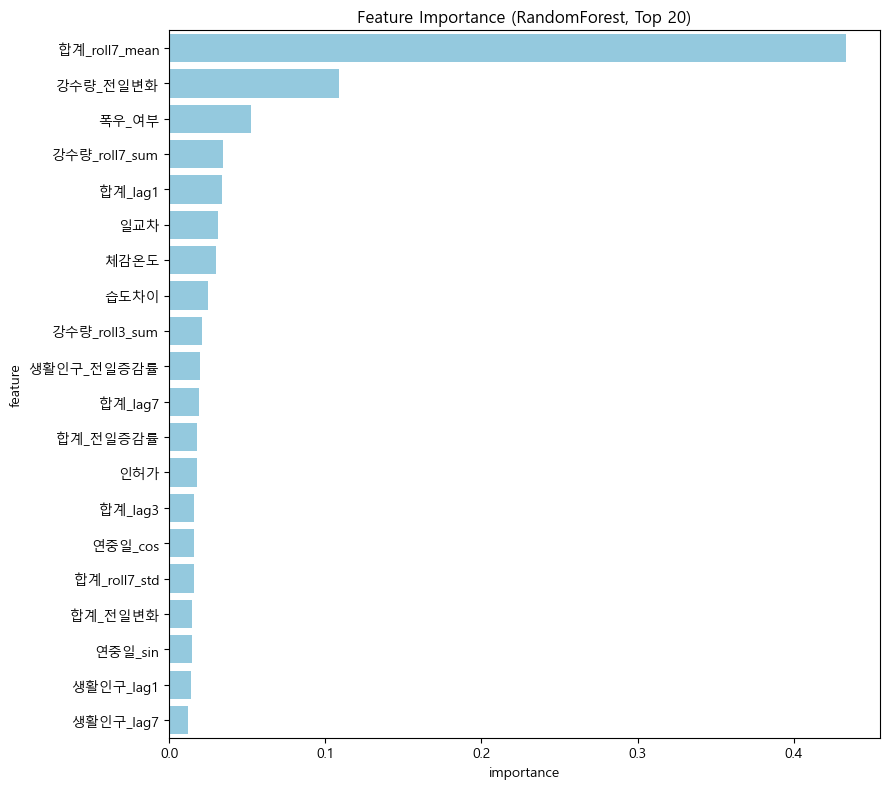

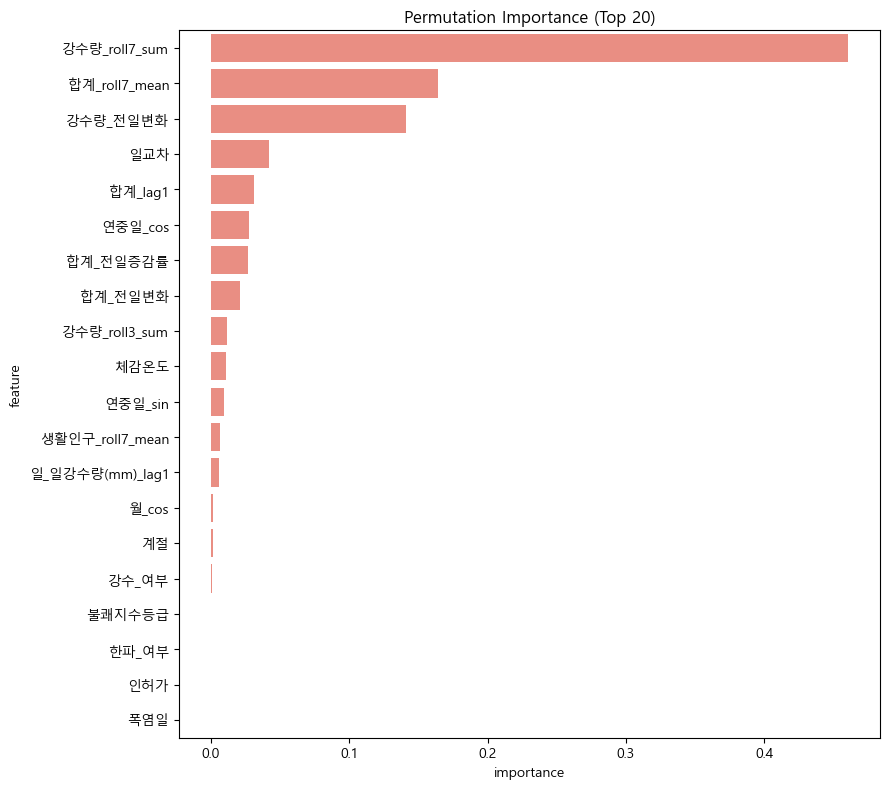

In [104]:
# %% [markdown]
# ## 3) Feature Importance (내장) + Permutation Importance
# - seaborn 0.14 경고 피하기 위해 hue 지정 또는 단색 사용

# %%
# (a) 내장 feature_importances_ (마지막 fold 모델 예시)
rf_last = rf_models[-1]
fi = (
    pd.DataFrame({'feature': X.columns, 'importance': rf_last.feature_importances_})
    .sort_values('importance', ascending=False)
)

plt.figure(figsize=(9,8))
sns.barplot(data=fi.head(20), x='importance', y='feature', color='skyblue')
plt.title("Feature Importance (RandomForest, Top 20)")
plt.tight_layout()
plt.show()

# (b) Permutation Importance (마지막 fold의 테스트 세트 기준)
#   - 더 직관적: 해당 feature를 섞으면 성능이 얼마나 떨어지나?
X_tr, X_te = X.iloc[tscv.split(X).__next__()[0]], X.iloc[tscv.split(X).__next__()[1]]  # 첫 fold 재구성용
y_tr, y_te = y.iloc[tscv.split(X).__next__()[0]], y.iloc[tscv.split(X).__next__()[1]]

rf_last.fit(X_tr, y_tr)
perm = permutation_importance(rf_last, X_te, y_te, n_repeats=10, random_state=42)
perm_df = (
    pd.DataFrame({'feature': X.columns, 'importance': perm.importances_mean})
    .sort_values('importance', ascending=False)
)

plt.figure(figsize=(9,8))
sns.barplot(data=perm_df.head(20), x='importance', y='feature', color='salmon')
plt.title("Permutation Importance (Top 20)")
plt.tight_layout()
plt.show()
